## **Song Lyric Analysis and Visualization**

This project uses a collection of many artists' lyrics from Kaggle and performs a comprehensive analysis and visualization of the lyrics.

### **Features**:
- **Data Collection & Preprocessing**:
  - Scans lyrics from '.txt' files, each named after an artist.
  - Cleans the text data: lowers case, removes punctuations and stopwords, and tokenizes.

- **Exploratory Data Analysis**:
  - Calculates and displays the total lyrics length, vocabulary size, and average sentiment.
  - Shows a distribution plot of lyrics length.
  
- **TF-IDF Analysis**:
  - Computes TF-IDF scores for each artist's lyrics.
  - Uses N-gram analysis to visualize patterns using heatmaps.
  - Visualizes top-N words via word clouds.

- **Embeddings & Similarity**:
  - Employs Doc2Vec for embeddings of cleaned lyrics.
  - Visualizes cosine similarities between artists using a heatmap.

- **Dimensionality Reduction & Clustering**:
  - Implements t-SNE for dimensionality reduction.
  - Determines optimal clusters using the Elbow method and KMeans.
  - Represents the t-SNE data and clusters visually.
---

In [1]:
# basics
import os
import pandas as pd
import numpy as np

# visualization and plotting
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from wordcloud import WordCloud

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

# similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---
# Data Collection and Preprocessing
Source text files of artist lyrics from Kaggle (or use your own). This converts the lyrics into a pandas dataframe with each row represented by the artist name.

After reading the dataset into a dataframe, stopwords are removed using NLTK, punctuation is removed, and text is lowercased

In [2]:
# Define directory path
dir_path = 'lyrics_by_artist'

# Create an empty list to store data
data = []

# Loop through each file in the directory
for filename in os.listdir(dir_path):
    if filename.endswith(".txt"):
        with open(os.path.join(dir_path, filename), 'r', encoding='utf-8') as f:
            lyrics = f.read()
            
            # Remove '.txt' to get the artist's name
            artist_name = filename[:-4]
            data.append([artist_name, lyrics])

# Convert the list into a DataFrame
df = pd.DataFrame(data, columns=['artist_name', 'lyrics'])

In [3]:
# If you haven't downloaded stopwords before, do it once
#nltk.download('stopwords')

In [4]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and return
    return ' '.join([word for word in tokens if word not in stop_words])

df['cleaned_lyrics'] = df['lyrics'].apply(preprocess_text)

---
# Exploratory Data Analysis
In the EDA process, the total lyrics length, vocabulary size, and average sentiment are calculated and displayed. Also, a distribution plot of the lyric lengths is shown.

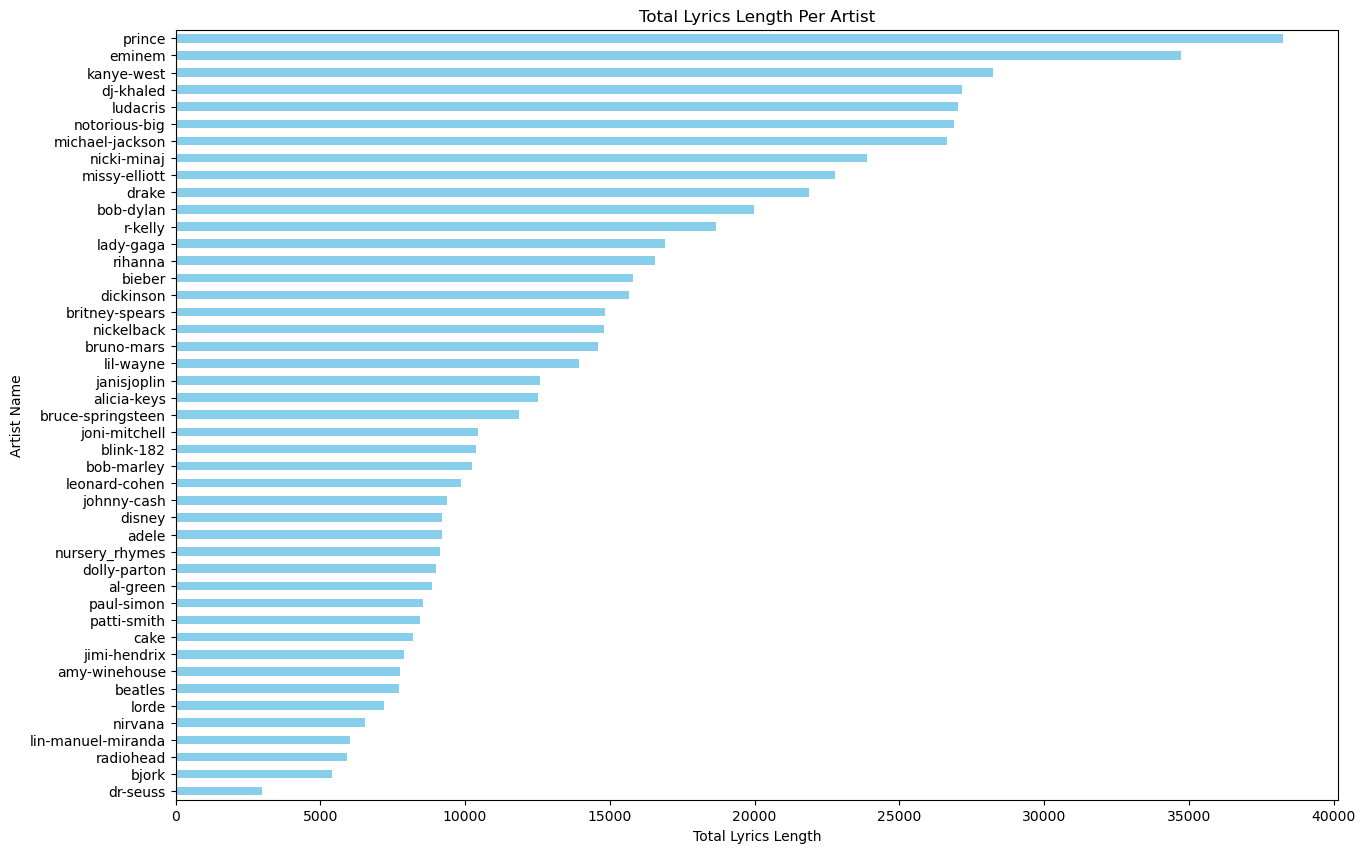

In [5]:
# Compute total lyrics length per artist
total_length_per_artist = df.groupby('artist_name')['cleaned_lyrics'].apply(lambda x: sum(x.str.split().str.len()))

# Plotting
plt.figure(figsize=(15, 10))
total_length_per_artist.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Total Lyrics Length')
plt.ylabel('Artist Name')
plt.title('Total Lyrics Length Per Artist')
plt.show()

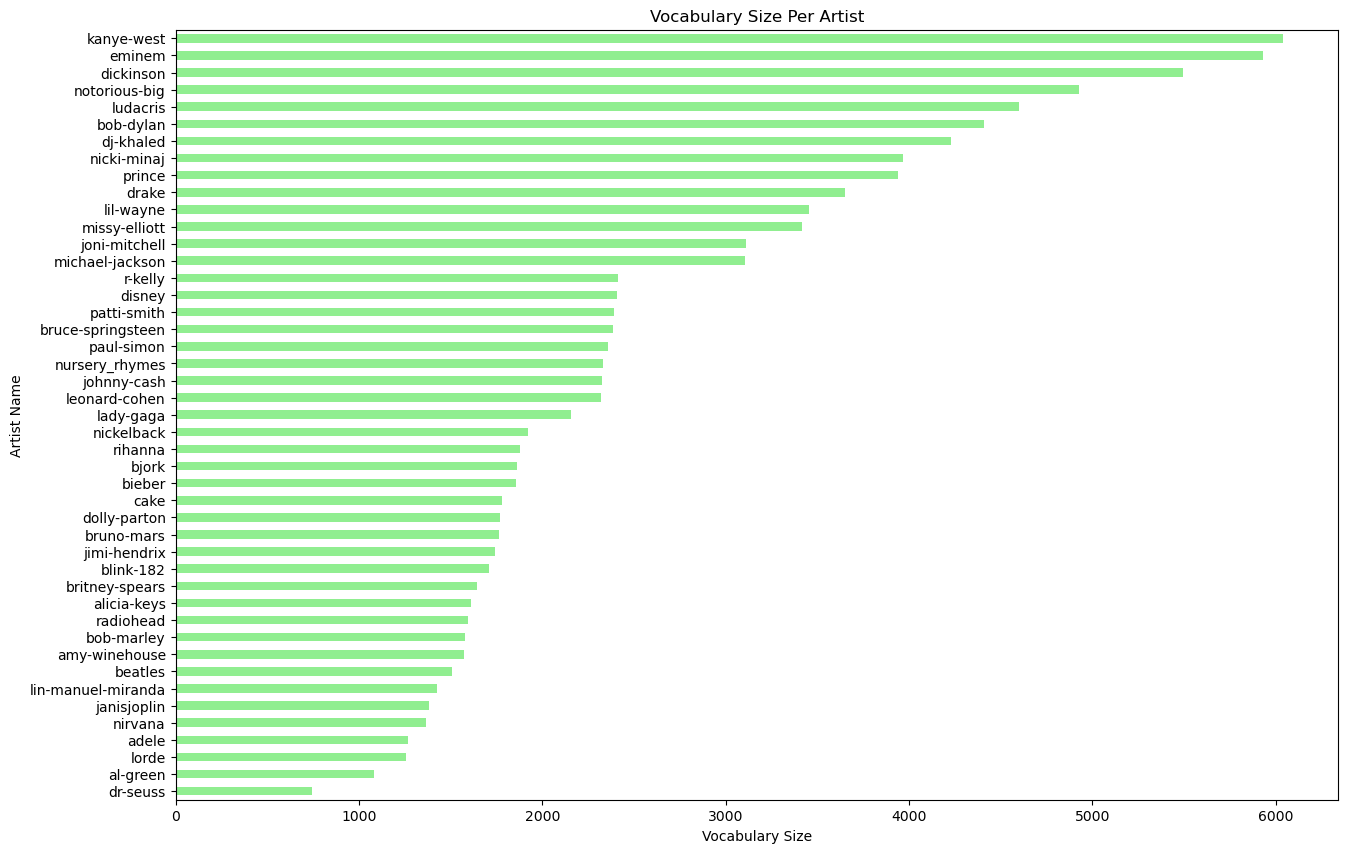

In [6]:
# Compute vocabulary size
vocab_size_per_artist = df.groupby('artist_name')['cleaned_lyrics'].apply(lambda x: len(set(' '.join(x).split())))
plt.figure(figsize=(15, 10))
vocab_size_per_artist.sort_values().plot(kind='barh', color='lightgreen')
plt.xlabel('Vocabulary Size')
plt.ylabel('Artist Name')
plt.title('Vocabulary Size Per Artist')
plt.show()

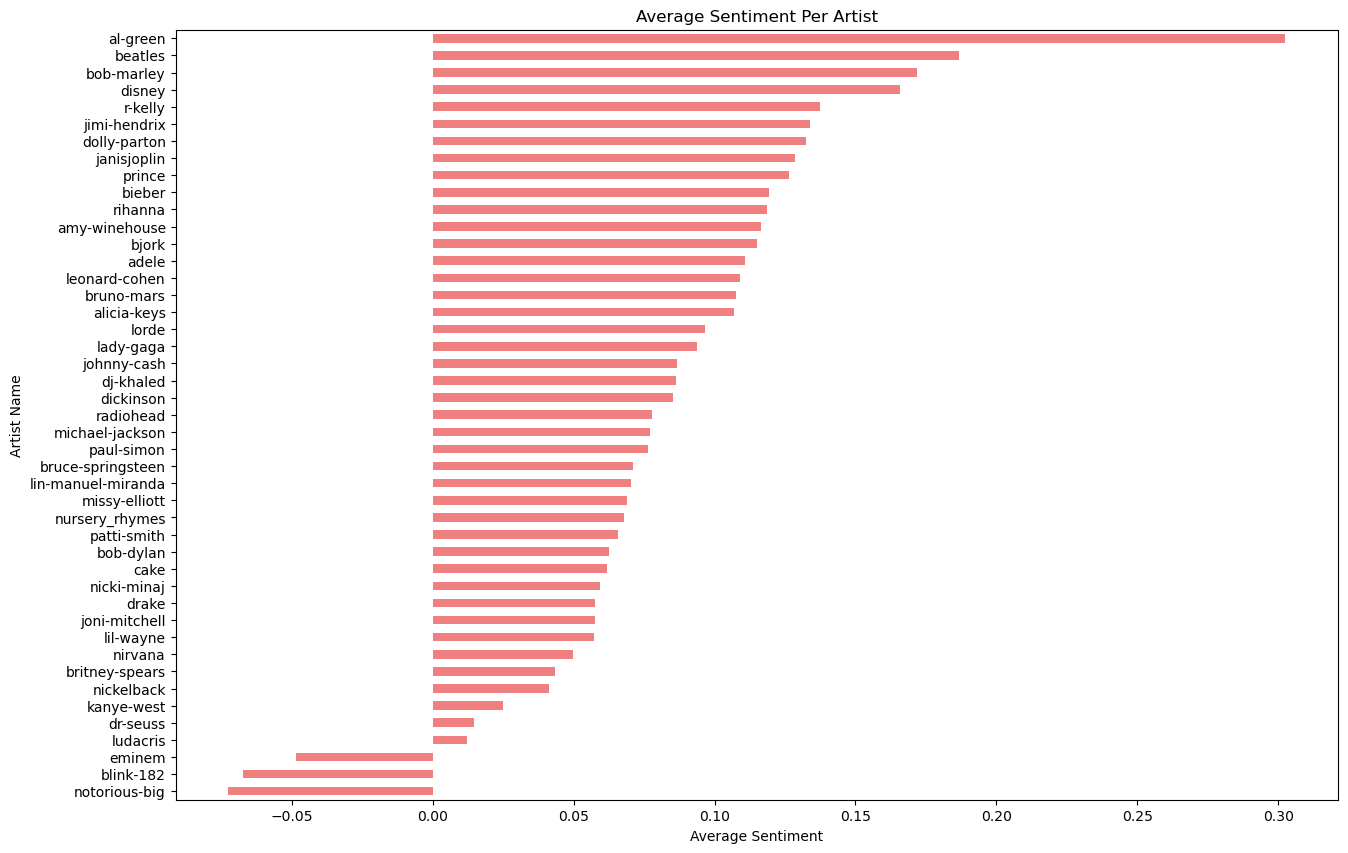

In [7]:
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Add a sentiment column to the dataframe
df['sentiment'] = df['cleaned_lyrics'].apply(get_sentiment)

# Compute average sentiment per artist
avg_sentiment_per_artist = df.groupby('artist_name')['sentiment'].mean()
plt.figure(figsize=(15, 10))
avg_sentiment_per_artist.sort_values().plot(kind='barh', color='lightcoral')
plt.xlabel('Average Sentiment')
plt.ylabel('Artist Name')
plt.title('Average Sentiment Per Artist')
plt.show()

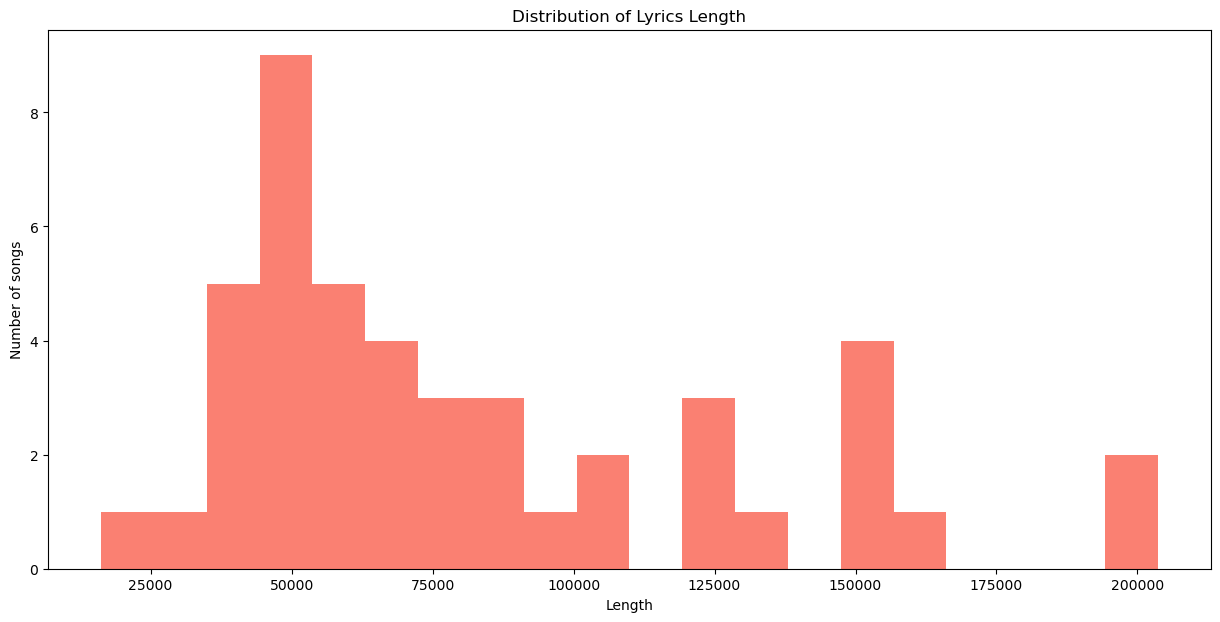

In [8]:
df['lyrics_length'] = df['cleaned_lyrics'].apply(len)
plt.figure(figsize=(15,7))
plt.hist(df['lyrics_length'], bins=20, color='salmon')
plt.title('Distribution of Lyrics Length')
plt.xlabel('Length')
plt.ylabel('Number of songs')
plt.show()

---
# TF-IDF Analysis
Computing TF-IDF scores for each of the artist's set of lyrics and visualizes them with a word cloud. Also visualizes the top N-grams across all artists using a heatmap

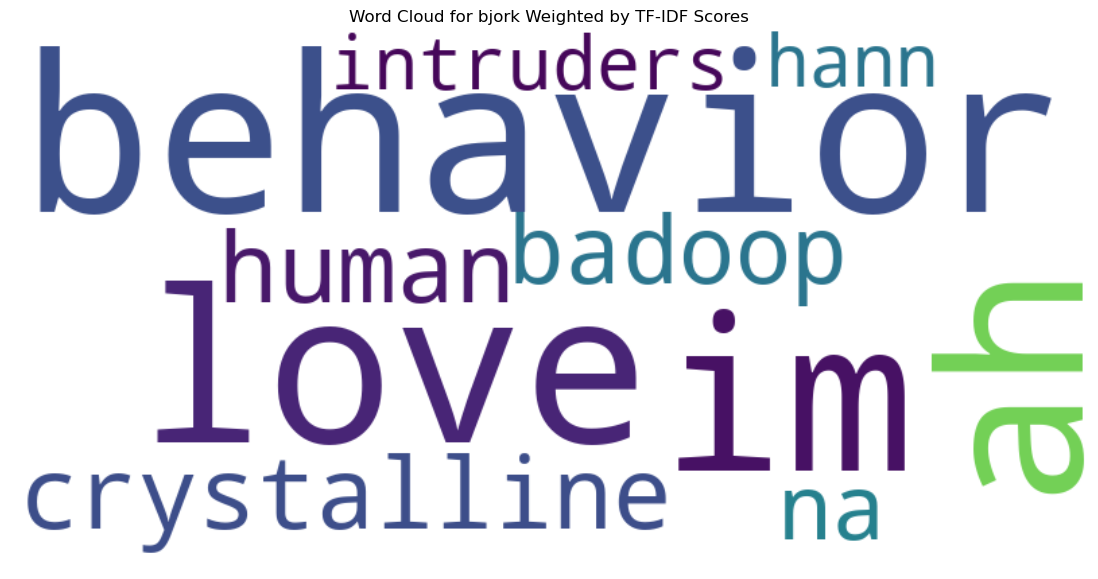

In [9]:
N = 10
tfidf = TfidfVectorizer(max_features=5000)
lyric_matrix = tfidf.fit_transform(df['cleaned_lyrics'])
tfidf_df = pd.DataFrame(lyric_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df['artist_name'])

# Top N words with highest TF-IDF scores for each artist
top_words_per_artist = {}
for artist in tfidf_df.index:
    top_words_per_artist[artist] = tfidf_df.loc[artist].nlargest(N).index.tolist()

def generate_wordcloud(artist_name):
    # Convert the series to dictionary for word cloud generation
    word_scores = tfidf_df.loc[artist_name].nlargest(N).to_dict()

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)
    
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {artist_name} Weighted by TF-IDF Scores')
    plt.show()

# Generate word cloud for a specific artist
generate_wordcloud('bjork')  # Change to whichever artist you'd like a wordcloud for

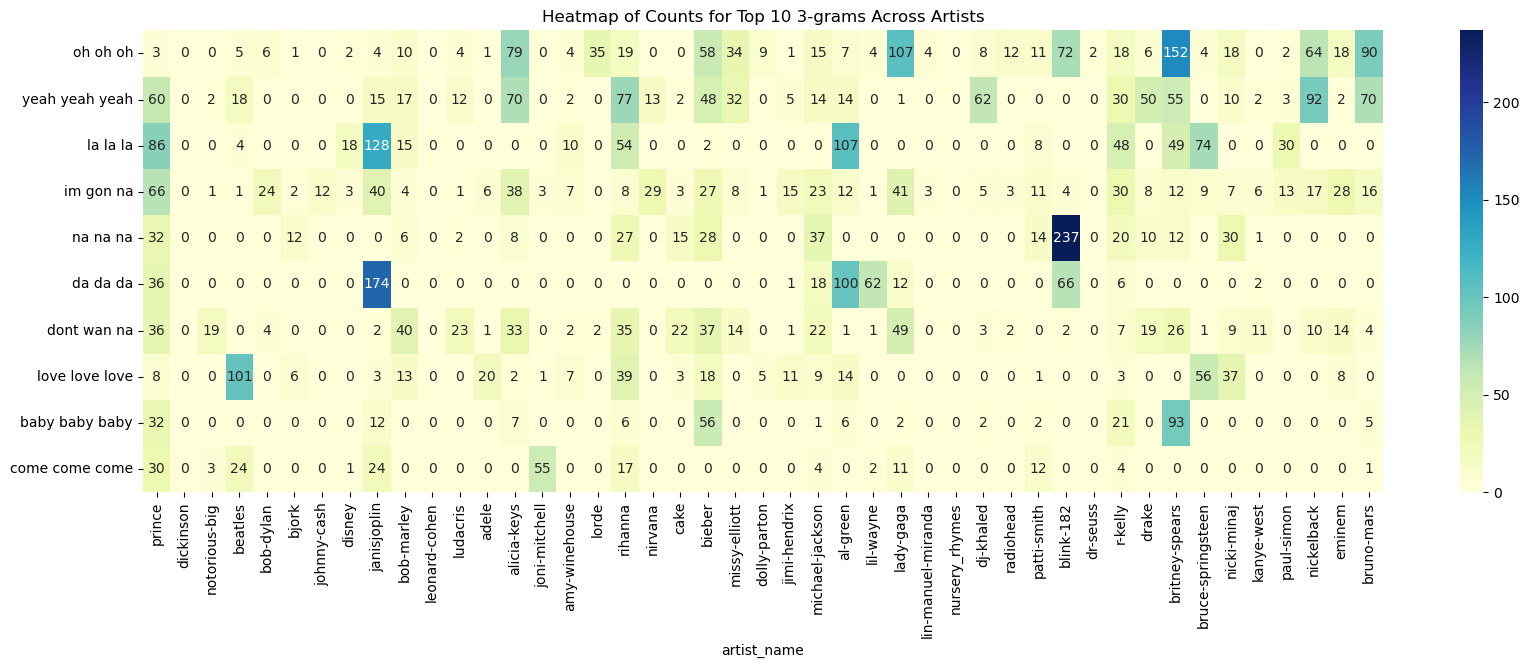

In [10]:
N_GRAMS = 3  # Change to 2 for bigrams, 4 for 4-grams, etc.
TOP_N = 10
vectorizer = CountVectorizer(ngram_range=(N_GRAMS, N_GRAMS), max_features=5000)
ngram_matrix = vectorizer.fit_transform(df['cleaned_lyrics'])
ngram_df = pd.DataFrame(ngram_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df['artist_name'])

# Top N N-grams with highest counts for each artist
top_ngrams_per_artist = {}
for artist in ngram_df.index:
    top_ngrams_per_artist[artist] = ngram_df.loc[artist].nlargest(TOP_N).index.tolist()

# Consider top N N-grams across all artists
top_ngrams = ngram_df.sum().nlargest(TOP_N).index
heatmap_data = ngram_df[top_ngrams].T

plt.figure(figsize=(20,6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="d")
plt.title(f'Heatmap of Counts for Top {TOP_N} {N_GRAMS}-grams Across Artists')
plt.show()

---
# Embeddings and Similarity
Uses Doc2Vec to generate embeddings of the cleaned lyrics for each of the artists and visualizes similarities across the embedding space using a heatmap

In [11]:
# Prepare data for Doc2Vec
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(df['cleaned_lyrics'])]

# Train a Doc2Vec model
model = Doc2Vec(vector_size=100, window=20, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Create a column for embeddings
df['embedding'] = df['cleaned_lyrics'].apply(lambda x: model.infer_vector(word_tokenize(x)))

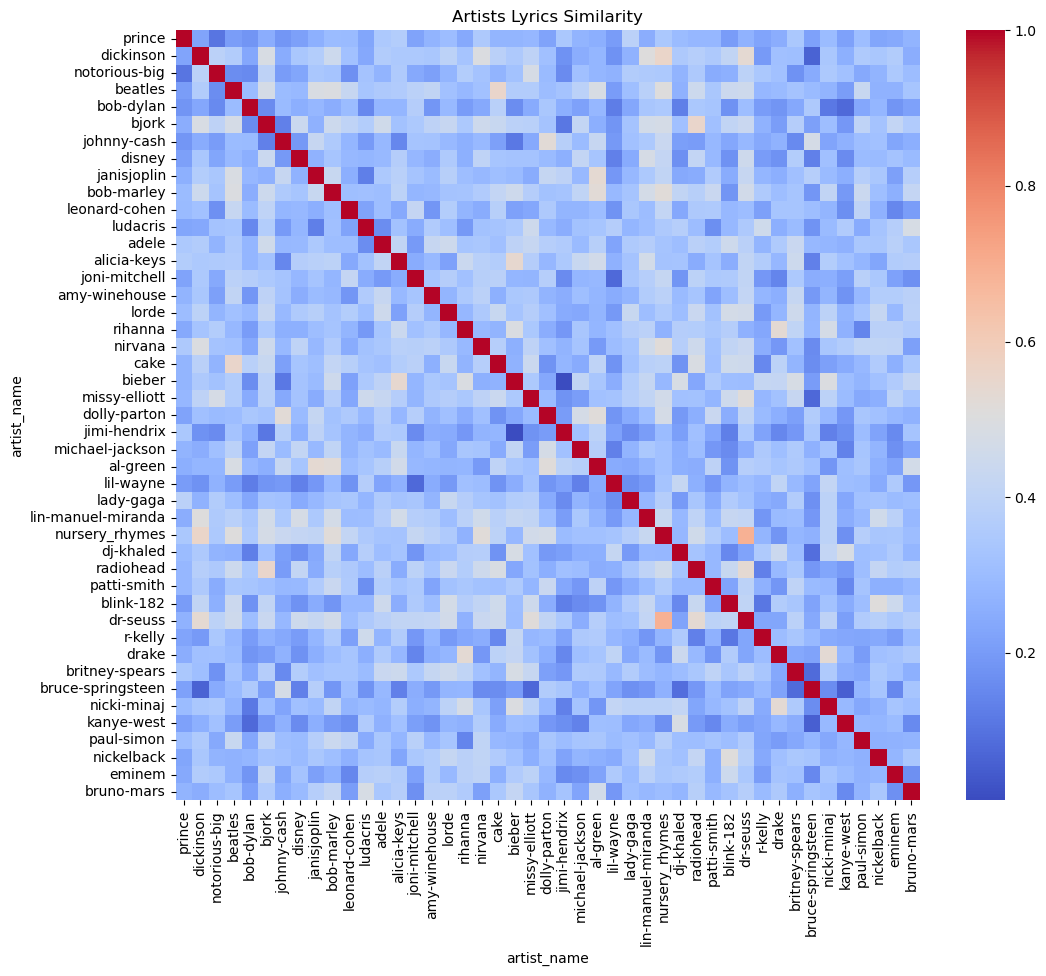

In [12]:
# Calculate cosine similarities
embeddings = list(df['embedding'])
similarities = cosine_similarity(embeddings)

# Convert similarities to DataFrame for better visualization
similarity_df = pd.DataFrame(similarities, index=df['artist_name'], columns=df['artist_name'])

plt.figure(figsize=(12,10))
sns.heatmap(similarity_df, cmap='coolwarm')
plt.title('Artists Lyrics Similarity')
plt.show()

---
# Dimensionality Reduction and Clustering
Using t-SNE for dimensionality reduction on the artist embeddings for visualization, then uses KMeans clustering on the t-SNE embeddings to discover similarities between artists. Optimal K value determined using the elbow method

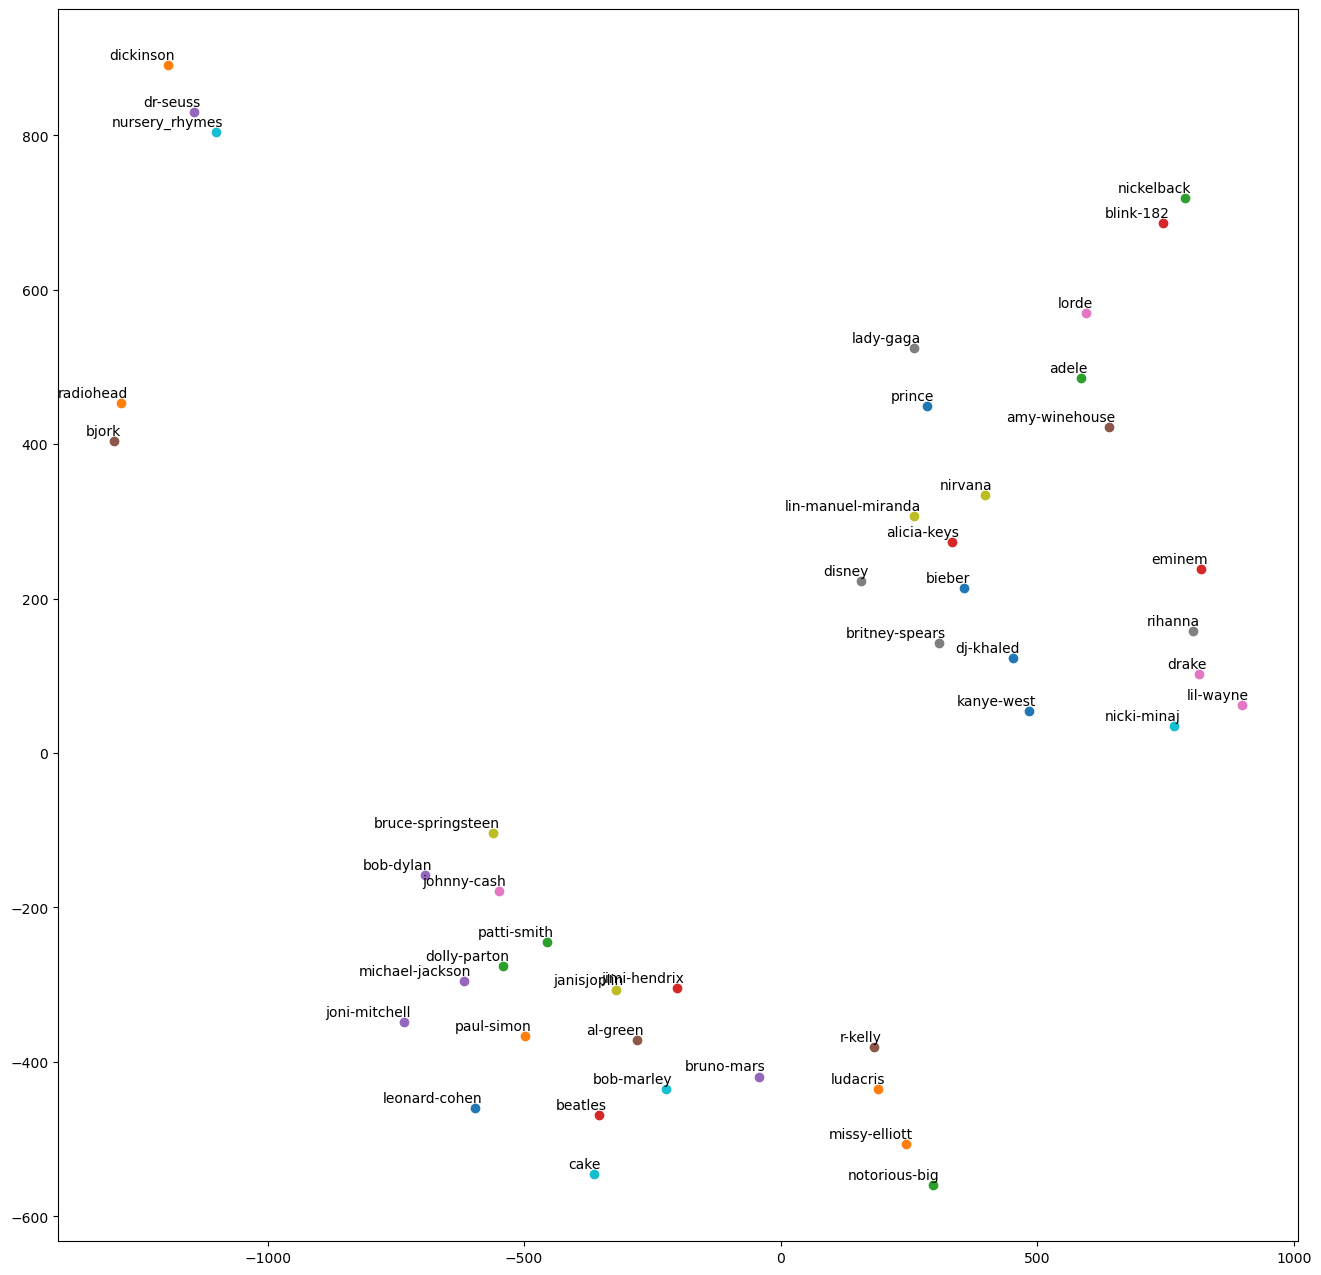

In [13]:
# Convert series of lists into a list of lists
list_of_lists = df['embedding'].tolist()

# Convert list of lists into a 2D numpy array
embeddings_array = pd.DataFrame(np.array(list_of_lists))

# Now apply t-SNE
tsne_model = TSNE(perplexity=1.75, learning_rate=200, n_components=2, init='pca', n_iter=25000, random_state=23)
new_values = tsne_model.fit_transform(embeddings_array)

df['tsne_x'] = new_values[:, 0]
df['tsne_y'] = new_values[:, 1]

plt.figure(figsize=(16, 16)) 
for i in range(len(new_values)):
    plt.scatter(new_values[i][0], new_values[i][1])
    plt.annotate(df['artist_name'].iloc[i],
                 xy=(new_values[i][0], new_values[i][1]),
                 xytext=(5,2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

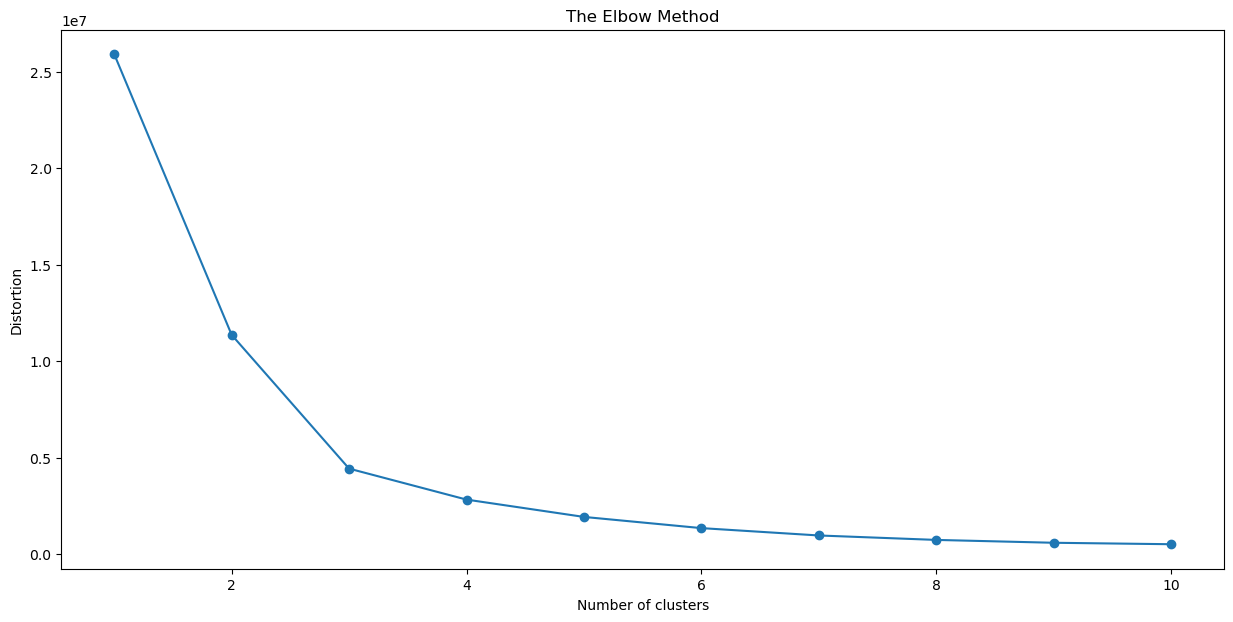

In [14]:
distortions = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(new_values)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(15,7))
plt.plot(range(1, 11), distortions, marker='o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

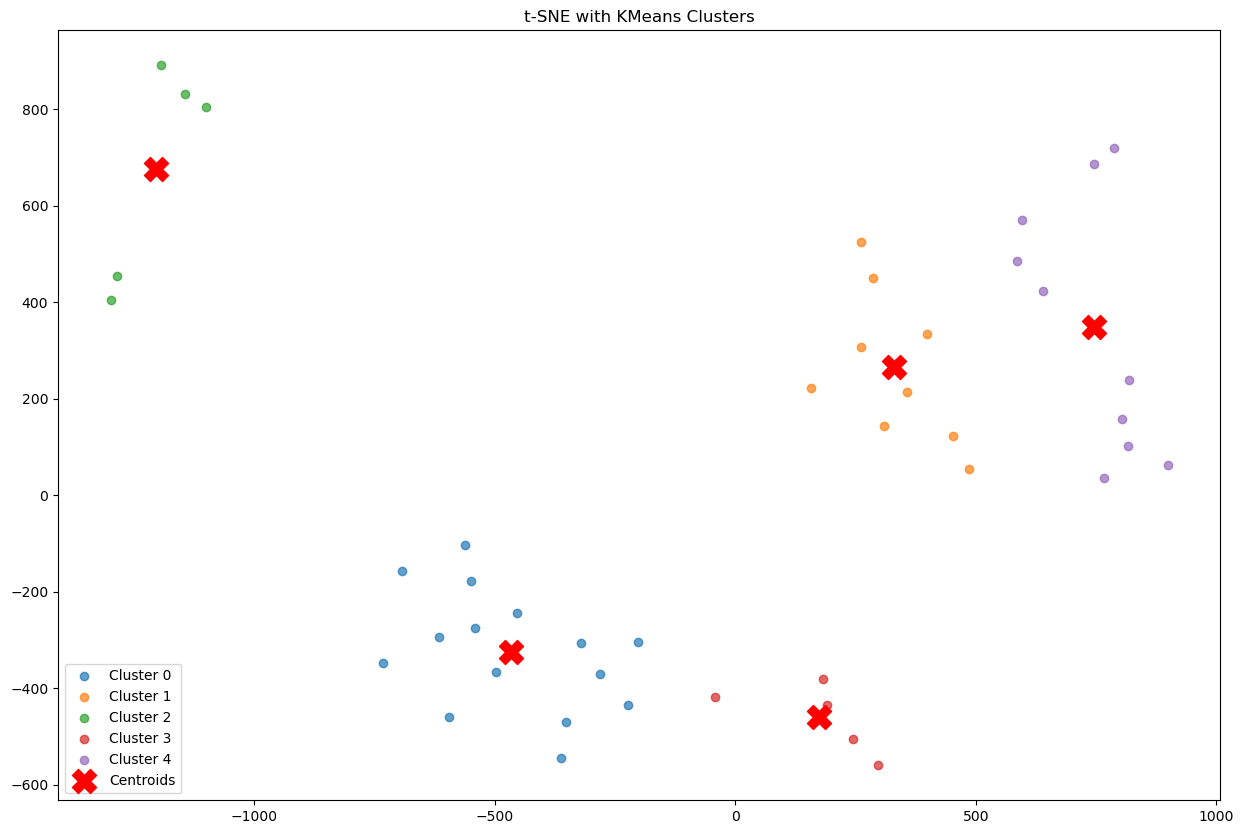

In [15]:
n_clusters = 5  # Based on reviewing the elbow plot

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(new_values)
cluster_labels = kmeans.labels_

plt.figure(figsize=(15,10))

for i in range(n_clusters):
    plt.scatter(new_values[cluster_labels == i, 0], 
                new_values[cluster_labels == i, 1], 
                label=f"Cluster {i}", 
                alpha=0.7)
    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroids')
plt.legend()
plt.title('t-SNE with KMeans Clusters')
plt.show()

In [16]:
# Add cluster labels to dataframe
df['cluster'] = cluster_labels

# Group by cluster label and aggregate artist names
clustered_artists = df.groupby('cluster')['artist_name'].agg(list)

# Print out artists in each cluster
for cluster, artists in clustered_artists.items():
    print(f"Cluster {cluster}:")
    for artist in artists:
        print(f" - {artist}")
    print("\n")

Cluster 0:
 - beatles
 - bob-dylan
 - johnny-cash
 - janisjoplin
 - bob-marley
 - leonard-cohen
 - joni-mitchell
 - cake
 - dolly-parton
 - jimi-hendrix
 - michael-jackson
 - al-green
 - patti-smith
 - bruce-springsteen
 - paul-simon


Cluster 1:
 - prince
 - disney
 - alicia-keys
 - nirvana
 - bieber
 - lady-gaga
 - lin-manuel-miranda
 - dj-khaled
 - britney-spears
 - kanye-west


Cluster 2:
 - dickinson
 - bjork
 - nursery_rhymes
 - radiohead
 - dr-seuss


Cluster 3:
 - notorious-big
 - ludacris
 - missy-elliott
 - r-kelly
 - bruno-mars


Cluster 4:
 - adele
 - amy-winehouse
 - lorde
 - rihanna
 - lil-wayne
 - blink-182
 - drake
 - nicki-minaj
 - nickelback
 - eminem


